In [0]:
#import the dataset
data = spark.read.csv("dbfs:/FileStore/tables/joined_cust_sales-3.csv", inferSchema = True, header = True, sep = ",").cache()

In [0]:
#check the data type of each feature
data.printSchema()

root
-- cust: integer (nullable = true)
-- address: string (nullable = true)
-- gender: string (nullable = true)
-- status: string (nullable = true)
-- ocupation: string (nullable = true)
-- age: integer (nullable = true)
-- product: string (nullable = true)
-- quantity: integer (nullable = true)
-- total_spending: integer (nullable = true)
-- purchase_date: string (nullable = true)

In [0]:
from pyspark.sql.functions import unix_timestamp, from_unixtime, to_date
data = data.withColumn('new_purchase_date', to_date(unix_timestamp('purchase_date', 'yyyy/MM/dd').cast("timestamp"))).drop('purchase_date')

In [0]:
#sort by cust and purchase date
data = data.orderBy(["cust", "new_purchase_date"], ascending=True)

In [0]:
#create flag of the i-th number of purchase (1st time, 2nd time, etc.) as a new feature
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, dense_rank
from pyspark.sql.functions import unix_timestamp, from_unixtime, to_date

window = Window.partitionBy(data['cust']).orderBy(data['new_purchase_date'])
data = data.select('*', rank().over(window).alias('flag'))

In [0]:
#create a new feature, total spending a customer spends on the client
resultsumtotal = data.groupBy('cust').sum('total_spending').select('cust','sum(total_spending)')

In [0]:
#create a new feature, the number of visit per customer
from pyspark.sql import functions as F
from pyspark.sql import Window
w = Window.partitionBy('cust')
data = data.withColumn('visit', F.max('flag').over(w)).where(F.col('flag') == F.col('visit')).drop('visit')

In [0]:
from pyspark.sql.functions import *

data = data.alias('data')
resultsumtotal = resultsumtotal.alias('resultsumtotal')

data2 = resultsumtotal.join(data, resultsumtotal['cust'] == data['cust'], 'left').drop(resultsumtotal['cust'])

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder
stages = []
cat_cols = ["cust", "address", "gender", "status", "ocupation", "flag"]

for cat_col in cat_cols:
  indexer = StringIndexer(inputCol = cat_col, outputCol = cat_col + "_index", stringOrderType = "alphabetAsc")
  encoder = OneHotEncoder(inputCols = [indexer.getOutputCol()], outputCols = [cat_col + "_vec"], dropLast = True)
  stages += [indexer, encoder]

pipeline = Pipeline(stages=stages)
data3 = pipeline.fit(data2).transform(data2)

In [0]:
# TODO: Build a better Regression pipeline
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler

assemblerInputs = ["cust_vec", "address_vec", "gender_vec", "status_vec", "ocupation_vec", "flag_vec", "age", "sum(total_spending)"]

vectorAssembler = VectorAssembler(inputCols = assemblerInputs, outputCol="assembler")

scaler = MinMaxScaler(inputCol="assembler",outputCol="features")


pipeline2 = Pipeline().setStages([
  vectorAssembler,
  scaler,
])

dataready = pipeline2.fit(data3).transform(data3)

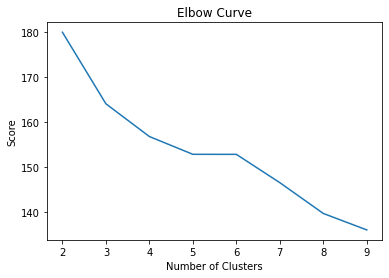

In [0]:
# Calculate cost and plot from the elbow method to define the optimum number of clusters
import numpy as np
import pandas as pd
from pyspark.ml.clustering import KMeans
cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(dataready)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [0]:
#according to the elbow method, our optimum number of clusters is 3
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
kmeans = KMeans().setK(3).setSeed(123)
model = kmeans.fit(dataready.select('features'))
predictions = model.transform(dataready)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.15415063047406838